# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [6]:
images.as_numpy_iterator().next()

b'data\\images\\424ac26b-f8df-11ee-abcb-005056c00008.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[213, 213, 225],
        [212, 212, 224],
        [209, 211, 224],
        ...,
        [ 11,  13,  12],
        [ 10,  12,  11],
        [ 10,  12,  11]],

       [[213, 213, 225],
        [212, 212, 224],
        [210, 212, 225],
        ...,
        [ 11,  13,  12],
        [ 10,  12,  11],
        [ 10,  12,  11]],

       [[212, 214, 226],
        [211, 213, 225],
        [211, 213, 226],
        ...,
        [ 11,  13,  12],
        [ 11,  13,  12],
        [ 11,  13,  12]],

       ...,

       [[ 59,  35,  25],
        [ 60,  38,  27],
        [ 61,  39,  28],
        ...,
        [ 46,  49,  42],
        [ 47,  50,  43],
        [ 48,  51,  44]],

       [[ 58,  33,  26],
        [ 57,  34,  26],
        [ 57,  34,  26],
        ...,
        [ 46,  49,  42],
        [ 46,  48,  43],
        [ 48,  50,  45]],

       [[ 62,  37,  30],
        [ 58,  35,  27],
        [ 56,  33,  25],
        ...,
        [ 44,  47,  40],
        [ 44,  46,  41],
        [ 46,  48,  43]]

In [10]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

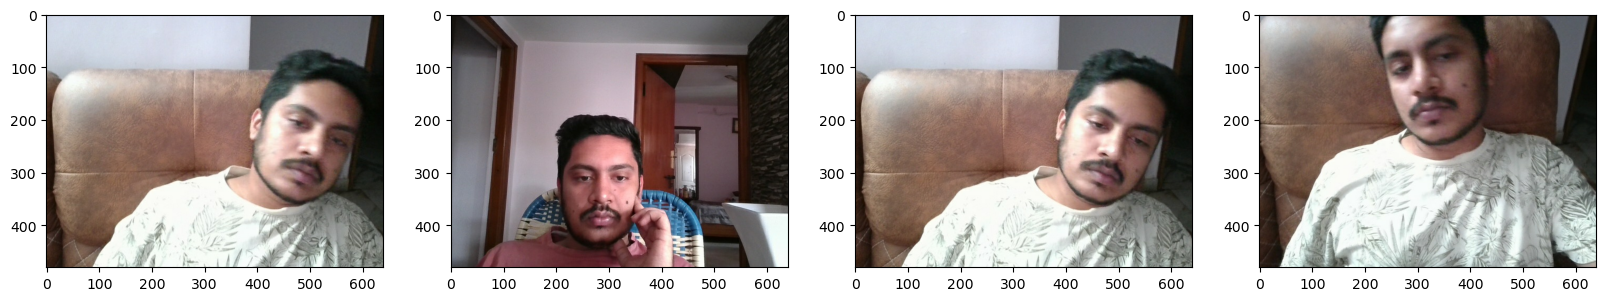

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [14]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [15]:
import albumentations as alb

c:\Users\tarun\anaconda3\envs\tf_gpu\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [16]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','image_3.jpg'))

In [24]:
with open(os.path.join('data', 'train', 'labels', 'image_3.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[166.86346863468637, 180.0369003690037],
 [366.49446494464945, 433.91143911439116]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[166.86346863468637, 180.0369003690037, 366.49446494464945, 433.91143911439116]

In [28]:
coords = list(np.divide(coords, [640,480,640,480]))

In [29]:
coords

[0.26072416974169743,
 0.3750768757687577,
 0.5726476014760148,
 0.9039821648216483]

### 4.4 Apply Augmentations and View Results

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [32]:
augmented['bboxes'][0][:]

(0.04191881918819187,
 0.3489708897088971,
 0.48554325543255433,
 0.9131365313653137)

In [33]:
augmented['bboxes']

[(0.04191881918819187,
  0.3489708897088971,
  0.48554325543255433,
  0.9131365313653137)]

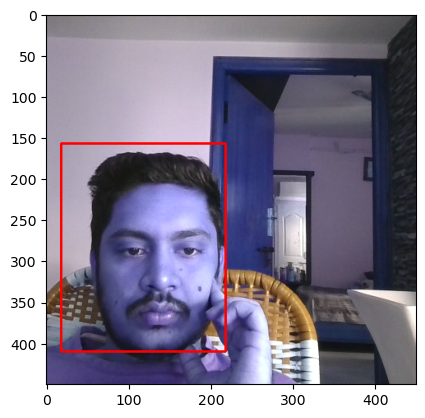

In [34]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [35]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.792320110701107, 0.41043972939729395, 0.3627767527675277, 0.006841943419434176, 'face'].
x_max is less than or equal to x_min for bbox [0.7438883763837638, 0.4504151291512915, 0.227859778597786, 0.02067958179581794, 'face'].
x_max is less than or equal to x_min for bbox [0.76695110701107, 0.4565651906519065, 0.3080027675276753, 0.04451107011070109, 'face'].
x_max is less than or equal to x_min for bbox [0.7508071955719557, 0.6172355473554736, 0.2566881918819189, 0.06526752767527674, 'face'].
x_max is less than or equal to x_min for bbox [0.6608625461254612, 0.75099938499385, 0.2699492619926199, 0.17981242312423124, 'face'].
x_max is less than or equal to x_min for bbox [0.7854012915129152, 0.43580873308733087, 0.38122693726937273, 0.02452337023370232, 'face'].
x_max is less than or equal to x_min for bbox [0.9214714022140222, 0.5626537515375154, 0.4383071955719557, 0.03682349323493233, 'face'].
x_max is less than or equal to x_min for bb

### 5.2 Load Augmented Images to Tensorflow Dataset

In [36]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [37]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [38]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [39]:
train_images.as_numpy_iterator().next()

array([[[0.01029412, 0.00637255, 0.        ],
        [0.01029412, 0.00637255, 0.        ],
        [0.01176471, 0.00784314, 0.        ],
        ...,
        [0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ]],

       [[0.01127451, 0.00735294, 0.        ],
        [0.01127451, 0.00735294, 0.        ],
        [0.01176471, 0.00784314, 0.        ],
        ...,
        [0.00392157, 0.01176471, 0.        ],
        [0.00392157, 0.01176471, 0.        ],
        [0.00392157, 0.01176471, 0.        ]],

       [[0.00784314, 0.00784314, 0.        ],
        [0.00784314, 0.00784314, 0.        ],
        [0.00778186, 0.00778186, 0.        ],
        ...,
        [0.00392157, 0.01176471, 0.        ],
        [0.00392157, 0.01176471, 0.        ],
        [0.00392157, 0.01176471, 0.        ]],

       ...,

       [[0.15980393, 0.15980393, 0.15980393],
        [0.14656863, 0.14656863, 0.14656863],
        [0.14748774, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [40]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.266   , 0.003485, 0.8276  , 0.5415  ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [45]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5100, 5100, 780, 780, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [46]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [47]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [48]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
len(train)

638

In [49]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.892  , 0.0594 , 1.     , 0.771  ],
        [0.2059 , 0.1521 , 0.848  , 0.7583 ],
        [0.1304 , 0.1567 , 0.7124 , 0.765  ],
        [0.     , 0.08386, 0.2812 , 0.7954 ],
        [0.5146 , 0.11993, 1.     , 0.744  ],
        [0.773  , 0.256  , 1.     , 0.871  ],
        [0.449  , 0.0835 , 1.     , 0.7295 ],
        [0.     , 0.283  , 0.3938 , 0.898  ]], dtype=float16))

### 7.3 View Images and Annotations

In [53]:
data_samples = train.as_numpy_iterator()

In [54]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


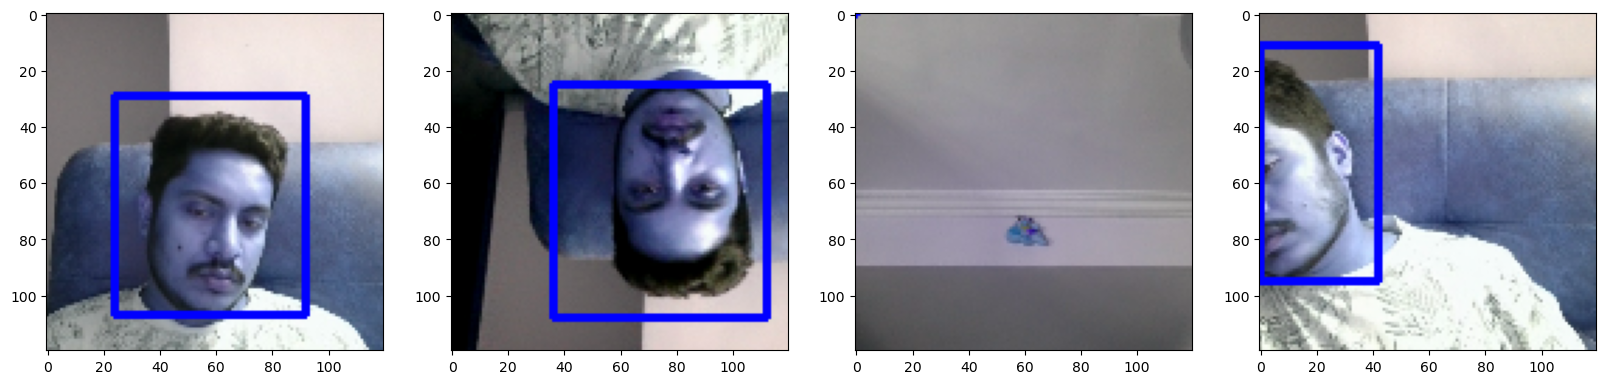

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming res is your result array and fig, ax are your subplots
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    # Draw rectangle on a copy of the image to avoid modifying the original
    image_with_rect = sample_image.copy()
    cv2.rectangle(image_with_rect, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 2)
    
    # Convert the image to RGB format (Matplotlib expects RGB images)
    image_with_rect_rgb = cv2.cvtColor(image_with_rect, cv2.COLOR_BGR2RGB)
    
    ax[idx].imshow(image_with_rect_rgb)
    
plt.show()

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [83]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Input

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze the convolutional base
base_model.trainable = False

# Add classification branch
classification_branch = GlobalMaxPooling2D()(base_model.output)
classification_branch = Dense(128, activation='relu')(classification_branch)
classification_output = Dense(1, activation='sigmoid', name='classification_output')(classification_branch)

# Add regression branch
regression_branch = GlobalMaxPooling2D()(base_model.output)
regression_branch = Dense(128, activation='relu')(regression_branch)
regression_output = Dense(4, activation='sigmoid', name='regression_output')(regression_branch)

# Create model
model = tf.keras.Model(inputs=base_model.input, outputs=[classification_output, regression_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'classification_output': 'binary_crossentropy', 'regression_output': 'mse'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})

# Display model summary
model.summary()
# Assuming you have train, val, and test datasets defined
# train, val, test = ...

# Define the number of epochs
epochs = 10

# Train the model
history = model.fit(train,
                    epochs=epochs,
                    validation_data=val)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 120, 120,  │      1,792 │ input_layer_3[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 120, 120,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 60, 60,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 60, 60,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 60, 60,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 30, 30,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 30, 30,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 30, 30,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 30, 30,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 15, 15,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 15, 15,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 15, 15,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 15, 15,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 7, 7, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 7, 7, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 7, 7, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 14,846,661 (56.64 MB)

 Trainable params: 131,973 (515.52 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

In [87]:
# Print shapes of the first batch of data from the training dataset
for batch in train.take(1):
    X_batch, y_batch = batch
    print("Input batch shape:", X_batch.shape)
    # Access the shape of y_batch directly
    print("Output batch shape:", y_batch[0].shape)  # Assuming the first element of y_batch contains the classification labels
    print("Output batch shape:", y_batch[1].shape)  # Assuming the second element of y_batch contains the regression labels



Input batch shape: (8, 120, 120, 3)
Output batch shape: (8, 1)
Output batch shape: (8, 4)


In [88]:
X_shape = X.shape
print("Shape of X:", X_shape)


Shape of X: (8, 120, 120, 3)


In [85]:
# Assuming you have defined your model as 'model'
# model = ...

# Get model predictions for the first batch of data
classification_pred, regression_pred = model.predict(X_batch)
print("Classification predictions shape:", classification_pred.shape)
print("Regression predictions shape:", regression_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Classification predictions shape: (8, 1)
Regression predictions shape: (8, 4)


In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [58]:
vgg = VGG16(include_top=False)

In [59]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [60]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [61]:
facetracker = build_model()

In [62]:
facetracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
X, y = train.as_numpy_iterator().next()

In [64]:
X.shape

(8, 120, 120, 3)

In [65]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


In [95]:
classes, coords

(array([[0.6320982 ],
        [0.55544245],
        [0.63386863],
        [0.6025941 ],
        [0.615034  ],
        [0.57309735],
        [0.56231904],
        [0.51685524]], dtype=float32),
 array([[0.6722324 , 0.6386825 , 0.6129756 , 0.44520393],
        [0.66045994, 0.6363199 , 0.61157554, 0.53205514],
        [0.6102258 , 0.67543375, 0.62172306, 0.49242577],
        [0.41237605, 0.6850928 , 0.58068895, 0.46714538],
        [0.64205253, 0.6688347 , 0.6652704 , 0.4343735 ],
        [0.5761533 , 0.57372284, 0.64842176, 0.5532868 ],
        [0.63998276, 0.6348175 , 0.60532606, 0.57088983],
        [0.6156796 , 0.637202  , 0.6010767 , 0.5841483 ]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [67]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [68]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

c:\Users\tarun\anaconda3\envs\tf_gpu\lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### 9.2 Create Localization Loss and Classification Loss

In [69]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [70]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [71]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.221021>

In [72]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5727601>

In [73]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.221021>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [74]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [75]:
model = FaceTracker(facetracker)

In [76]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [77]:
logdir='logs'

In [78]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [82]:
y[0]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1]], dtype=uint8)

In [79]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

### 10.3 Plot Performance

In [81]:
tf.print(tf.shape(y[0]))

[8 1]


In [80]:
tf.print(tf.shape(classes))

[8 1]


In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()